**Name:** Sara Abdelghafar<br>
**ID:** 300266850

**Note:** Scores slightly fluctuate due to the randomness of the neural network outputs.

## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope

In [ ]:
data = pd.read_csv('traindata.csv')
test = pd.read_csv('testdata.csv')

Check if any of the features have a constant value and drop them from list of features.

In [ ]:
for i in data.columns:
  if(len(np.unique(data[i])) == 1):
    print(i)

num_outbound_cmds
is_host_login


In [ ]:
X_train = data.drop(labels = ['ID', 'num_outbound_cmds', 'is_host_login', 'Class'], axis = 1)
y_train = data['Class']
X_test = test.drop(labels = ['ID', 'num_outbound_cmds', 'is_host_login'], axis = 1)
print(X_train.shape)
print(X_test.shape)

(23002, 40)
(22501, 40)


Hot encoding categorical features.

In [ ]:
joint_data = pd.concat([X_train, X_test])

In [ ]:
joint_data = pd.get_dummies(data= joint_data, columns = ['protocol_type', 'service', 'flag'])

In [ ]:
X_train = joint_data.iloc[:X_train.shape[0],]
print(X_train.shape)
X_test = joint_data.iloc[X_train.shape[0]:,]
print(X_test.shape)

(23002, 118)
(22501, 118)


Scaling all columns excpet the hot encoded ones using MinMaxScaling.

In [ ]:
# make a copy of dataframe
scaled_features = X_train.copy()

cols = ['duration', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']
       
features = scaled_features[cols]

# Use scaler of choice; here Standard scaler is used
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[cols] = features

In [ ]:
scaled_test = X_test.copy()
       
features = scaled_test[cols]

features = scaler.transform(features.values)

scaled_test[cols] = features

## Sparse Autoencoder

Feature Extraction using Autoencoder. <br>
Source Code:
https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/

In [ ]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')

In [ ]:
epochs = 10
reg_param = 0.001
add_sparsity = 'yes'
learning_rate = 1e-3
batch_size = 64

Reproducibility from Pytorch documentation:
https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
g = torch.Generator()
g.manual_seed(0)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [ ]:
class NSLDataset(Dataset):
  def __init__(self, data_frame):
      self.NSL_frame = data_frame
  def __len__(self):
    return len(self.NSL_frame)
  def __getitem__(self, idx):
    NSL = self.NSL_frame[idx,:].astype('float64')
    return torch.from_numpy(NSL)

In [ ]:
X_train = np.array(scaled_features)
X_test = np.array(scaled_test)

In [ ]:
NSL_train = NSLDataset(X_train)
trainloader = DataLoader(NSL_train, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)

NSL_test = NSLDataset(X_test)
testloader = DataLoader(NSL_test, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)

In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
        nn.Linear(in_features=118, out_features=64),
        nn.Linear(in_features=64, out_features=32),
        nn.Linear(in_features=32, out_features=16))
 
        # decoder 
        self.decoder = nn.Sequential(
        nn.Linear(in_features=16, out_features=32),
        nn.Linear(in_features=32, out_features=64),
        nn.Linear(in_features=64, out_features=118))
 
    def forward(self, x):
        # encoding
        x = self.encoder(x)
        # decoding
        x = self.decoder(x)
        return x
model = SparseAutoencoder().to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
model_children = list(model.children())

In [ ]:
# define the sparse loss function
def sparse_loss(autoencoder, data):
    loss = 0
    values = data
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        loss += torch.mean(torch.abs(values))
    return loss

In [ ]:
def fit(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(X_train)/dataloader.batch_size)):
        counter += 1
        feature = data.float()
        feature = feature.to(device)
        optimizer.zero_grad()
        outputs = model(feature)
        mse_loss = criterion(outputs, feature)
        if add_sparsity == 'yes':
            l1_loss = sparse_loss(model, feature)
            # add the sparsity penalty
            loss = mse_loss + reg_param * l1_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    print(f"Train Loss: {loss:.3f}")
    return epoch_loss

In [ ]:
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(X_test)/dataloader.batch_size)):
            counter += 1
            feature = data.float()
            feature = feature.to(device)
            outputs = model(feature)
            loss = criterion(outputs, feature)
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {loss:.3f}")  
    return epoch_loss

In [ ]:
# train and validate the autoencoder neural network
train_loss = []
val_loss = []
start = time.time()
PATH = 'encoder_weights.pth'
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    if(epoch == epochs - 1):
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
            }, PATH)
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")

Epoch 1 of 10
Training


360it [00:00, 437.38it/s]                         


Train Loss: 0.033
Validating


352it [00:00, 1550.66it/s]                         


Val Loss: 0.034
Epoch 2 of 10
Training


360it [00:00, 445.23it/s]                         


Train Loss: 0.029
Validating


352it [00:00, 1543.99it/s]                         


Val Loss: 0.025
Epoch 3 of 10
Training


360it [00:00, 445.19it/s]                         


Train Loss: 0.023
Validating


352it [00:00, 1541.46it/s]                         


Val Loss: 0.021
Epoch 4 of 10
Training


360it [00:00, 455.91it/s]                         


Train Loss: 0.015
Validating


352it [00:00, 1683.08it/s]                         


Val Loss: 0.015
Epoch 5 of 10
Training


360it [00:00, 440.95it/s]                         


Train Loss: 0.019
Validating


352it [00:00, 1563.88it/s]


Val Loss: 0.017
Epoch 6 of 10
Training


360it [00:00, 446.01it/s]                         


Train Loss: 0.018
Validating


352it [00:00, 1571.17it/s]                         


Val Loss: 0.016
Epoch 7 of 10
Training


360it [00:00, 448.22it/s]                         


Train Loss: 0.012
Validating


352it [00:00, 1540.12it/s]                         


Val Loss: 0.013
Epoch 8 of 10
Training


360it [00:00, 452.31it/s]                         


Train Loss: 0.018
Validating


352it [00:00, 1660.91it/s]                         


Val Loss: 0.015
Epoch 9 of 10
Training


360it [00:00, 463.19it/s]                         


Train Loss: 0.018
Validating


352it [00:00, 1680.52it/s]                         


Val Loss: 0.016
Epoch 10 of 10
Training


360it [00:00, 460.56it/s]                         


Train Loss: 0.010
Validating


352it [00:00, 1508.78it/s]                         

Val Loss: 0.010
0.174 minutes


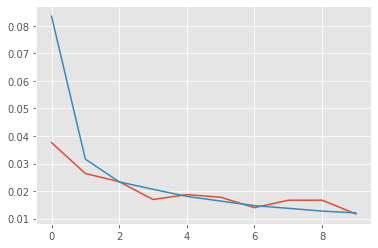

In [ ]:
plt.plot(val_loss)
plt.plot(train_loss)

In [ ]:
model = SparseAutoencoder().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

ckpt = torch.load('encoder_weights.pth')
model.load_state_dict(ckpt['model_state_dict'])
optimizer.load_state_dict(ckpt['optimizer_state_dict'])

In [ ]:
encoded_train = []
model.eval()
for i, data in tqdm(enumerate(trainloader), total=int(len(X_train)/trainloader.batch_size)):
  feature = data.float()
  feature = feature.to(device)
  encoded_train.extend(model.encoder(feature).detach().numpy())
encoded_train = np.array(encoded_train)

360it [00:00, 2007.10it/s]                         


In [ ]:
encoded_test = []
model.eval()
for i, data in tqdm(enumerate(testloader), total=int(len(X_test)/testloader.batch_size)):
  feature = data.float()
  feature = feature.to(device)
  encoded_test.extend(model.encoder(feature).detach().numpy())
enocded_test = np.array(encoded_test)

352it [00:00, 2010.10it/s]                         


In [ ]:
encoded_train, encoded_val, y_train, y_val = train_test_split(encoded_train, y_train, random_state = 0, stratify = y_train)

## Random Forest
Encoded features and Radom forest yielded (score= 0.89).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF_tuned = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=0.0006, 
                                  min_samples_leaf=3, bootstrap = True, oob_score = True, warm_start=True)

In [ ]:
RF_tuned.fit(encoded_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=0.0006,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=True)

In [ ]:
pred_RF_tr = RF_tuned.predict(encoded_train)

In [ ]:
pred_RF_val = RF_tuned.predict(encoded_val)

In [ ]:
print(classification_report(y_val, pred_RF_val))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3001
           1       0.99      1.00      0.99      2750

    accuracy                           0.99      5751
   macro avg       0.99      0.99      0.99      5751
weighted avg       0.99      0.99      0.99      5751



In [ ]:
pred_RF = RF_tuned.predict(encoded_test)

## XGBoost
Encoded features and XGboost yielded (score= 0.92).

In [ ]:
! pip install --upgrade xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'auc', learning_rate = 0.005, n_estimators = 300)
xgb.fit(encoded_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.005, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=2,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [ ]:
pred_xgb_tr = xgb.predict(encoded_train)

In [ ]:
pred_xgb_val = xgb.predict(encoded_val)

In [ ]:
print(classification_report(y_val, pred_xgb_val))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3001
           1       0.99      1.00      0.99      2750

    accuracy                           0.99      5751
   macro avg       0.99      0.99      0.99      5751
weighted avg       0.99      0.99      0.99      5751



In [ ]:
pred_xgb = xgb.predict(encoded_test)

# Stacking

I took the prediction of the random forest and xgboost and passed them to multilayer perceptron along with the original input and target.<br>
This approach yielded (score= 0.91).

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(18, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x
clf = Classifier().to(device)

In [ ]:
cross_entropy_criterion = nn.CrossEntropyLoss()
optimizer_adagrad = optim.Adagrad(clf.parameters(), lr=0.008)

In [ ]:
class FullNSLDataset(Dataset):
  def __init__(self, data, labels):
      self.X = data
      self.y = labels
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    X = self.X[idx,:].astype('float64')
    y = self.y[idx].astype('float64')
    sample = {'X': torch.from_numpy(X), 'y': torch.tensor(y).type(torch.long)}
    return sample

In [ ]:
stack_train = pd.DataFrame(data = encoded_train)
stack_train['random_forest'] = pred_RF_tr
stack_train['xgboost'] = pred_xgb_tr
stack_train = np.array(stack_train)
y_train = np.array(y_train)

In [ ]:
stack_val = pd.DataFrame(data= encoded_val)
stack_val['random_forest '] = pred_RF_val
stack_val['xgboost'] = pred_xgb_val
stack_val = np.array(stack_val)
y_val = np.array(y_val)

In [ ]:
stack_test = pd.DataFrame(data = encoded_test)
stack_test['random_forest'] = pred_RF
stack_test['xgboost'] = pred_xgb
stack_test = np.array(stack_test)

In [ ]:
clf_trainset = FullNSLDataset(stack_train, y_train)
clf_loader = DataLoader(clf_trainset, batch_size = 10)
clf_valset = FullNSLDataset(stack_val, y_val)
clf_valloader = DataLoader(clf_valset, batch_size=10)
clf_testset = NSLDataset(stack_test)
clf_testloader = DataLoader(clf_testset, batch_size=10)

In [ ]:
def fit_clf(model, dataloader, epoch):
    print('Training')
    running_loss = 0.0
    counter = 0
    for i, Sample in tqdm(enumerate(dataloader), total=int(len(stack_train)/dataloader.batch_size)):
        counter += 1
        X = Sample['X'].float()
        X = X.to(device)
        y = Sample['y']
        y = y.to(device)
        optimizer_adagrad.zero_grad()
        output = model(X)
        cross_entropy_loss = cross_entropy_criterion(output, y)
        cross_entropy_loss.backward()
        optimizer_adagrad.step()
        running_loss += cross_entropy_loss.item()
    epoch_loss = running_loss / counter
    print(f"Train Loss: {cross_entropy_loss}")
    return epoch_loss

In [ ]:
def validate_clf(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, Sample in tqdm(enumerate(dataloader), total=int(len(stack_val)/dataloader.batch_size)):
            counter += 1
            X = Sample['X'].float()
            X = X.to(device)
            y = Sample['y']
            y = y.to(device)
            outputs = model(X)
            cross_entropy_loss = cross_entropy_criterion(outputs, y)
            running_loss += cross_entropy_loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {cross_entropy_loss:.3f}")  
    return epoch_loss

In [ ]:
# train and validate the autoencoder neural network
train_loss = []
val_loss = []
start = time.time()
clf.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_clf(clf, clf_loader, epoch)
    val_epoch_loss = validate_clf(clf, clf_valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

end = time.time()
 
print(f"{(end-start)/60:.3} minutes")

Epoch 1 of 10
Training


1726it [00:01, 1147.52it/s]                          


Train Loss: 0.32185161113739014
Validating


576it [00:00, 2593.68it/s]                         


Val Loss: 0.322
Epoch 2 of 10
Training


1726it [00:01, 1144.38it/s]                          


Train Loss: 0.2607528567314148
Validating


576it [00:00, 2459.03it/s]                         


Val Loss: 0.261
Epoch 3 of 10
Training


1726it [00:01, 1154.79it/s]                          


Train Loss: 0.23102211952209473
Validating


576it [00:00, 2627.83it/s]                         


Val Loss: 0.231
Epoch 4 of 10
Training


1726it [00:01, 1136.59it/s]                          


Train Loss: 0.21293874084949493
Validating


576it [00:00, 2712.27it/s]                         


Val Loss: 0.213
Epoch 5 of 10
Training


1726it [00:01, 1152.65it/s]                          


Train Loss: 0.20062494277954102
Validating


576it [00:00, 2594.21it/s]                         


Val Loss: 0.201
Epoch 6 of 10
Training


1726it [00:01, 1155.61it/s]                          


Train Loss: 0.19163207709789276
Validating


576it [00:00, 2656.24it/s]                         


Val Loss: 0.192
Epoch 7 of 10
Training


1726it [00:01, 1158.95it/s]                          


Train Loss: 0.18474318087100983
Validating


576it [00:00, 2485.92it/s]                         


Val Loss: 0.185
Epoch 8 of 10
Training


1726it [00:01, 1108.76it/s]                          


Train Loss: 0.17927652597427368
Validating


576it [00:00, 2700.04it/s]                         


Val Loss: 0.179
Epoch 9 of 10
Training


1726it [00:01, 1145.75it/s]                          


Train Loss: 0.17482049763202667
Validating


576it [00:00, 2598.98it/s]                         


Val Loss: 0.175
Epoch 10 of 10
Training


1726it [00:01, 1158.62it/s]                          


Train Loss: 0.17111153900623322
Validating


576it [00:00, 2667.73it/s]                         

Val Loss: 0.171
0.291 minutes


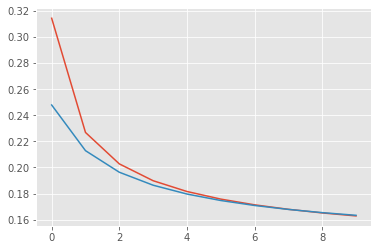

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
mlp_pred = []
clf.eval()
for i, data in tqdm(enumerate(clf_testloader), total=int(len(stack_test)/trainloader.batch_size)):
  X = data.float()
  X = X.to(device)
  mlp_pred.extend(clf(X).detach().numpy())
mlp_pred = [np.argmax(p) for p in mlp_pred]

2251it [00:00, 4706.18it/s]


#### Submission


In [ ]:
submission = pd.DataFrame({"ID":np.arange(0,len(mlp_pred)), "Class":mlp_pred})
submission.to_csv("kaggle30.csv", index=False)
# !cp kaggle16.csv "drive/My Drive/"